In [4]:
import os
import glob
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
from osgeo import gdal
import matplotlib.pyplot as plt

import convlstm

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
df = pd.read_csv(
    "/Users/kyla/Downloads/modis_mod13q1_v61_664388d58994a262.csv", encoding="cp1252"
).reset_index()
print(len(df))
df.head(1)

60


index             Local Granule ID  \
0  MOD13Q1.A2020065.h11v03.061.2020330152641.hdf  MOD13Q1.A2020065.h11v03.061   

    Entity ID Acquisition Start Date  Acquisition End Date  \
0  2020/03/05             2020/03/20                    11   

   Horizontal Tile Number Vertical Tile Number  Day/Night Indicator  \
0                       3                  Day                   61   

  Version Number Product Generation Algorithm  ... Center Longitude dec  \
0          6.1.0                       Passed  ...              59.7053   

  NW Corner Lat dec NW Corner Long dec  NE Corner Lat dec NE Corner Long dec  \
0         -143.1316            60.1231          -120.3249            49.7821   

  SE Corner Lat dec SE Corner Long dec SW Corner Lat dec  \
0          -92.9934            49.5789         -109.9708   

            SW Corner Long dec  Display ID  
0  MOD13Q1.A2020065.h11v03.061  2421092260  

[1 rows x 38 columns]

In [3]:
filenames = sorted(glob.glob("files/*.hdf"))
len(filenames), filenames[0]

(60, 'files/MOD13Q1.A2020065.h11v03.061.2020330152641.hdf')

In [4]:
ds = gdal.Open(filenames[0])

# get the path for a specific subdataset
subds = [sd for sd, descr in ds.GetSubDatasets()]
subds

['HDF4_EOS:EOS_GRID:"files/MOD13Q1.A2020065.h11v03.061.2020330152641.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days NDVI"',
 'HDF4_EOS:EOS_GRID:"files/MOD13Q1.A2020065.h11v03.061.2020330152641.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days EVI"',
 'HDF4_EOS:EOS_GRID:"files/MOD13Q1.A2020065.h11v03.061.2020330152641.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days VI Quality"',
 'HDF4_EOS:EOS_GRID:"files/MOD13Q1.A2020065.h11v03.061.2020330152641.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days red reflectance"',
 'HDF4_EOS:EOS_GRID:"files/MOD13Q1.A2020065.h11v03.061.2020330152641.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days NIR reflectance"',
 'HDF4_EOS:EOS_GRID:"files/MOD13Q1.A2020065.h11v03.061.2020330152641.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days blue reflectance"',
 'HDF4_EOS:EOS_GRID:"files/MOD13Q1.A2020065.h11v03.061.2020330152641.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days MIR reflectance"',
 'HDF4_EOS:EOS_GRID:"files/MOD13Q1.A2020065.h11v03.061.2020330152641

In [101]:
metadata = ds.GetMetadata()
lats = [float(x) for x in metadata["GRINGPOINTLATITUDE.1"].split(", ")]
lons = [float(x) for x in metadata["GRINGPOINTLONGITUDE.1"].split(", ")]
coords = list(zip(lats, lons))
coords

[(49.5789113103597, -109.970765585882),
 (59.7052699100447, -143.13163662668),
 (60.1231268939801, -120.324853219622),
 (49.7821369581876, -92.9933532661929)]

In [103]:
min(lats) - 0.1, max(lats) + 0.1, min(lons) - 0.1, max(lons) + 0.1

(49.4789113103597, 60.2231268939801, -143.23163662668, -92.8933532661929)

In [5]:
dates = []
for filename in filenames:
    row = df[df["index"] == filename.split("/")[-1]].iloc[0].values
    file_dates = [datetime.strptime(date, "%Y/%m/%d") for date in row[2:4]]
    dates.append(file_dates)
dates[0]

[datetime.datetime(2020, 3, 5, 0, 0), datetime.datetime(2020, 3, 20, 0, 0)]

In [6]:
def get_ndvi_file(filename):
    try:
        # open the main HDF
        ds = gdal.Open(filename)

        # get the path for a specific subdataset
        subds = [sd for sd, descr in ds.GetSubDatasets()]

        # open and read it like normal
        ndvi_ds = gdal.Open([x for x, y in ds.GetSubDatasets() if "NDVI" in x][0])
        data = ndvi_ds.ReadAsArray()
        ndvi_ds = None
        return data
    except:
        pass

In [7]:
%%time
ndvi_files = [get_ndvi_file(filename) for filename in filenames]
len(ndvi_files), ndvi_files[0].shape

CPU times: user 47.5 s, sys: 2.5 s, total: 50 s
Wall time: 54 s


(60, (4800, 4800))

In [8]:
years = list(range(2020, 2025))
info = {year: [] for year in years}
for date, data in zip(dates, ndvi_files):
    year = date[0].year
    info[year].append((data, date))
{k: len(v) for k, v in info.items()}

{2020: 14, 2021: 14, 2022: 14, 2023: 14, 2024: 4}

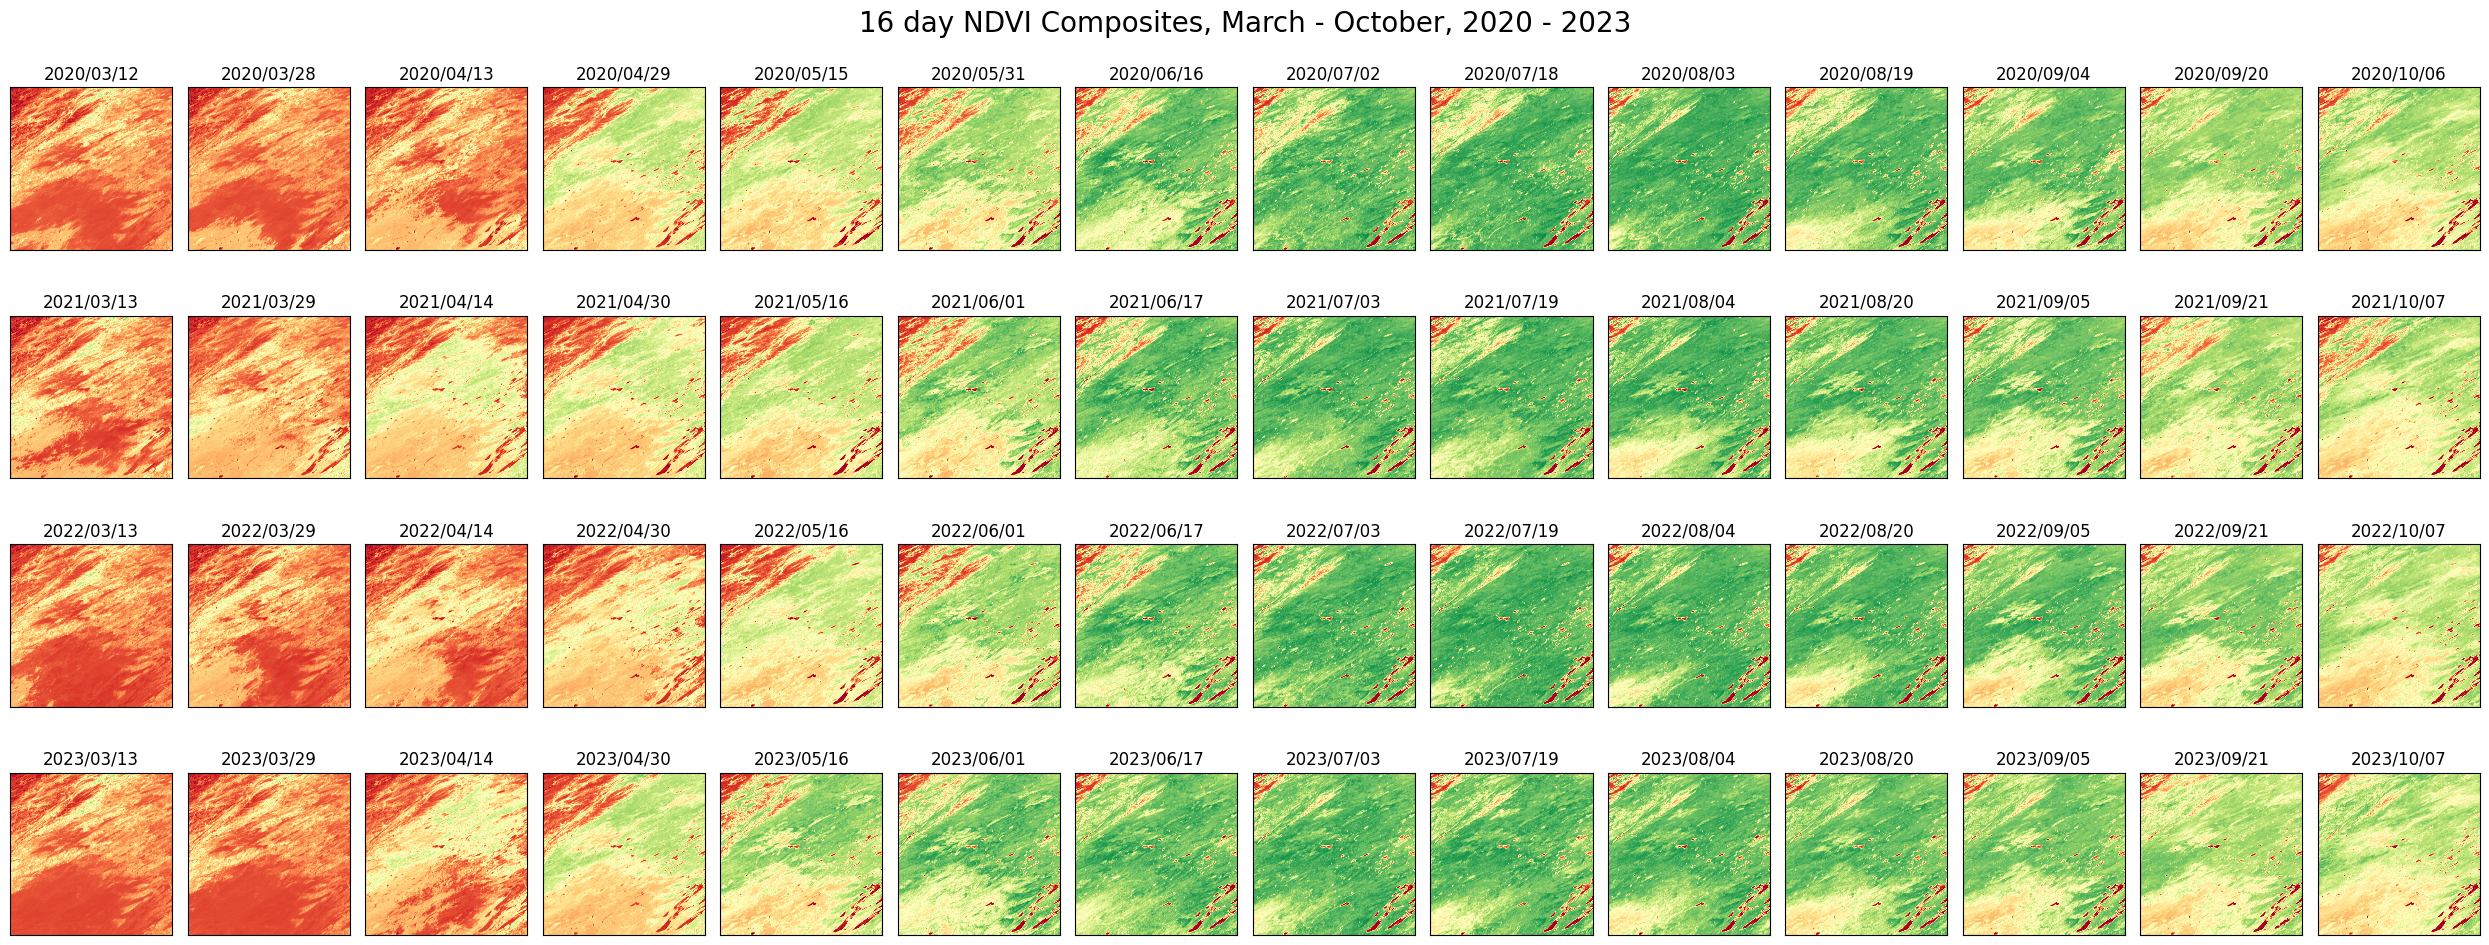

In [16]:
nfiles = len(ndvi_files)
rows = len(years[:-1])
# rows = int(np.sqrt(nfiles))
cols = np.max([len(x) for x in info.values()])

vmin = -2000
vmax = 10000

fig, axes = plt.subplots(rows, cols, figsize=(25, 10))  # , sharex=True, sharey=True)
for r, year in enumerate(years[:-1]):
    for c, (data, date_list) in enumerate(info[year]):
        date = date_list[0] + (date_list[1] - date_list[0]) / 2
        date = datetime.strftime(date, "%Y/%m/%d")
        axes[r, c].set_title(date)
        if type(data) == np.ndarray:
            axes[r, c].imshow(
                data,
                cmap=plt.cm.RdYlGn,
                vmin=vmin,
                vmax=vmax,
            )
        axes[r, c].axes.xaxis.set_ticks([])
        axes[r, c].axes.yaxis.set_ticks([])

plt.suptitle("16 day NDVI Composites, March - October, 2020 - 2023", fontsize=20)
plt.tight_layout()
plt.show()

In [30]:
ndvi_arr = np.dstack(ndvi_files)
ndvi_arr.shape

(4800, 4800, 60)

In [40]:
ndvi_arr_flat = ndvi_arr.reshape(
    ndvi_arr.shape[0] * ndvi_arr.shape[1], ndvi_arr.shape[2]
)
ndvi_arr_flat.shape

(23040000, 60)

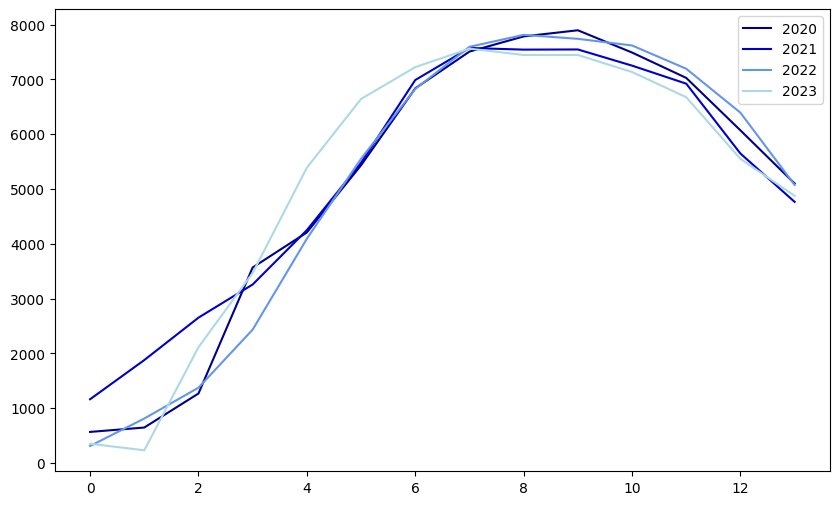

In [56]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = plt.plot(np.median(ndvi_arr_flat[:, :14], axis=0), color="darkblue", label=2020)
ax = plt.plot(
    np.median(ndvi_arr_flat[::, 14 : 14 * 2], axis=0), color="mediumblue", label=2021
)
ax = plt.plot(
    np.median(ndvi_arr_flat[:, 14 * 2 : 14 * 3], axis=0),
    color="cornflowerblue",
    label=2022,
)
ax = plt.plot(
    np.median(ndvi_arr_flat[:, 14 * 3 : 14 * 4], axis=0), color="lightblue", label=2023
)

plt.legend()